In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import torch
from torch import nn, Tensor, optim, cuda
from torch.utils.data import TensorDataset, DataLoader

In [2]:
# 데이터 로딩
train_X_data = pd.read_csv('./train_set/train_X_data.csv', index_col='datetime', parse_dates=True)
test_X_data = pd.read_csv('./test_set/test_X_data.csv', index_col='datetime', parse_dates=True)
train_Y_data = pd.read_csv('./train_set/train_Y_data.csv', index_col='datetime', parse_dates=True)
test_Y_data = pd.read_csv('./test_set/test_Y_data.csv', index_col='datetime', parse_dates=True)

test_Y_data_df = test_Y_data

# X 데이터의 모든 열을 숫자형으로 변환
# apply(pd.to_numeric, errors='coerce')를 사용하면 변환되지 않는 값이 NaN으로 변환
train_X_data = train_X_data.apply(pd.to_numeric, errors='coerce') 
test_X_data = test_X_data.apply(pd.to_numeric, errors='coerce')

# 타겟 변수의 'Kp' 열을 숫자형으로 변환
train_Y_data['Kp'] = pd.to_numeric(train_Y_data['Kp'], errors='coerce')
train_Y_data = train_Y_data['Kp'].values.astype(float) # MSELoss를 위해 실수형으로 변환
test_Y_data['Kp'] = pd.to_numeric(test_Y_data['Kp'], errors='coerce')
test_Y_data = test_Y_data['Kp'].values.astype(float) # MSELoss를 위해 실수형으로 변환

# print(train_X_data.head)
# print(train_Y_data.head)

In [3]:
if torch.backends.mps.is_available():
    device = 'mps'
    mps_device = torch.device(device)
    torch.cuda.manual_seed_all(777)
    print(device)
else:
    print ("MPS device not found.")

torch.manual_seed(777)

mps


In [4]:
# 데이터 스케일링
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()

# 훈련 데이터에 대해 스케일러 학습 및 변환
train_X_data = scaler_X.fit_transform(train_X_data)
# train_Y_data = scaler_Y.fit_transform(train_Y_data)

# 테스트 데이터에 대해 스케일러 변환
test_X_data = scaler_X.transform(test_X_data)
# test_Y_data = scaler_Y.transform(test_Y_data)

In [5]:
# 데이터 변환 (torch.Tensor로 변환)
train_X_tensor = torch.tensor(train_X_data, dtype=torch.float32)
train_Y_tensor = torch.tensor(train_Y_data, dtype=torch.float32)

# 배치 크기 정의
batch_size = 64

# TensorDataset과 DataLoader를 사용하여 배치 생성
dataset = TensorDataset(train_X_tensor, train_Y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [6]:
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLPModel, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_sizes[0])# 첫 번째 선형 계층 정의
        self.batch_norm1 = nn.BatchNorm1d(hidden_sizes[0])# 첫 번째 배치 정규화 계층  (신경망의 학습을 안정화)
        self.linear2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.batch_norm2 = nn.BatchNorm1d(hidden_sizes[1])
        self.linear3 = nn.Linear(hidden_sizes[1], output_size)

        self.relu = nn.ReLU()

        # Initialize weights using Xavier uniform initialization
        torch.nn.init.xavier_uniform_(self.linear1.weight)# 첫 번째 선형 계층의 가중치를 Xavier uniform 방식으로 초기화
        torch.nn.init.xavier_uniform_(self.linear2.weight)# gradient vanishing(기울기 소실) 및 gradient exploding(기울기 폭발) 문제를 완화
        torch.nn.init.xavier_uniform_(self.linear3.weight)

        # Initialize biases to zero
        nn.init.zeros_(self.linear1.bias)# 첫 번째 선형 계층의 편향을 0으로 초기화
        nn.init.zeros_(self.linear2.bias)
        nn.init.zeros_(self.linear3.bias)

    def forward(self, x):
        x = self.linear1(x) # 첫 번째 선형 변환 적용
        x = self.batch_norm1(x)# 첫 번째 배치 정규화 적용
        x = self.relu(x)# ReLU 활성화 함수 적용

        x = self.linear2(x)
        x = self.batch_norm2(x)
        x = self.relu(x)

        x = self.linear3(x)  # No batch norm after the last linear layer
        return x

In [7]:
# 모델 초기화
input_size = train_X_data.shape[1]   # input data feature 수, X_train의 열 수
hidden_sizes = [26, 13] # hidden state의 크기, 첫 번째 은닉층은 26개, 두 번째 은닉층은 13개
output_size = 10   # output data feature 수, 회귀 문제이므로 출력 크기는 1
model = MLPModel(input_size, hidden_sizes, output_size).to(device)

optimizer = optim.SGD(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [8]:
def train(dataloader,model,optimizer,criterion):

  total_batch = len(dataloader)
  model.train()

  for epoch in range(300):
    avg_cost = 0

    for X, Y in dataloader:
      
      optimizer.zero_grad()

      X = X.to(device)
      Y = Y.to(device)

      output = model(X)
            
      # CrossEntropyLoss는 내부적으로 소프트맥스 계산을 포함하므로 output을 그대로 사용
      loss = criterion(output, Y)

      loss.backward()
      optimizer.step()

      avg_cost += loss / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

In [9]:
train(dataloader,model,optimizer,criterion)

Epoch: 0001 cost = 2.302927971
Epoch: 0002 cost = 2.059471846
Epoch: 0003 cost = 1.903421164
Epoch: 0004 cost = 1.792935491
Epoch: 0005 cost = 1.709664941
Epoch: 0006 cost = 1.646913528
Epoch: 0007 cost = 1.597501636
Epoch: 0008 cost = 1.558398008
Epoch: 0009 cost = 1.527024388
Epoch: 0010 cost = 1.501719832
Epoch: 0011 cost = 1.478380680
Epoch: 0012 cost = 1.456531405
Epoch: 0013 cost = 1.440641403
Epoch: 0014 cost = 1.424249172
Epoch: 0015 cost = 1.411045671
Epoch: 0016 cost = 1.397669077
Epoch: 0017 cost = 1.385369897
Epoch: 0018 cost = 1.376703143
Epoch: 0019 cost = 1.362034082
Epoch: 0020 cost = 1.353877306
Epoch: 0021 cost = 1.346436381
Epoch: 0022 cost = 1.338104844
Epoch: 0023 cost = 1.329665065
Epoch: 0024 cost = 1.324101686
Epoch: 0025 cost = 1.315976381
Epoch: 0026 cost = 1.312245131
Epoch: 0027 cost = 1.305539370
Epoch: 0028 cost = 1.301992655
Epoch: 0029 cost = 1.297629952
Epoch: 0030 cost = 1.289918184
Epoch: 0031 cost = 1.286968589
Epoch: 0032 cost = 1.284724474
Epoch: 0

In [10]:
test_X_tensor = torch.tensor(test_X_data, dtype=torch.float32)

# TensorDataset과 DataLoader를 사용하여 배치 생성
dataset = TensorDataset(test_X_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=False)

In [11]:
def evaluate_and_save(dataloader, model, file_path):
    model.eval()  # 모델을 평가 모드로 설정
    predictions = []

    with torch.no_grad():  # 기울기 계산 비활성화
        for X, in dataloader:  # 데이터 로더에서 데이터 배치를 반복
            X = X.to(device)  # 데이터를 적절한 디바이스로 이동 (CPU 또는 GPU)
            output = model(X)  # 모델로부터 예측 수행
            predicted_labels = torch.argmax(output, dim=1)
            predictions.extend(predicted_labels.cpu().numpy())  # 예측값을 리스트에 저장

    # 예측 결과를 DataFrame으로 변환
    predicted_df = pd.DataFrame(predictions, index=test_Y_data_df.index, columns=['Prediction'])
    # 결과를 CSV 파일로 저장
    predicted_df.to_csv(file_path)
    return predicted_df

In [12]:
# 함수 호출
file_path = "./Prediction/MLP___Performance.csv"
y_pred = evaluate_and_save(dataloader, model, file_path)

In [13]:
# WRMSE 함수 정의
def WRMSE(predictions, answers):
    sum_answer = answers.sum().item()  # DataFrame에서 직접 합 계산
    if sum_answer == 0:
        return torch.sqrt(torch.tensor(0.001, dtype=torch.float))
    weights = answers / sum_answer  # 각 값에 대해 가중치 계산
    loss = (weights * (predictions - answers).pow(2)).sum().item()  # 가중치 적용한 오차 제곱합
    return torch.sqrt(torch.tensor(loss, dtype=torch.float))

In [14]:
test_rmse = np.sqrt(mean_squared_error(test_Y_data, y_pred))

print(f'Test RMSE: {test_rmse}')

# 텐서 변환
test_targets_tensor = torch.tensor(test_Y_data_df['Kp'].values, dtype=torch.float32)
test_predictions_tensor = torch.tensor(y_pred['Prediction'].values, dtype=torch.float32)

# WRMSE 계산
wrmse_value = WRMSE(test_predictions_tensor, test_targets_tensor)
print(f'Test WRMSE: {wrmse_value.item()}')

Test RMSE: 0.7434646770542614
Test WRMSE: 0.8056553602218628


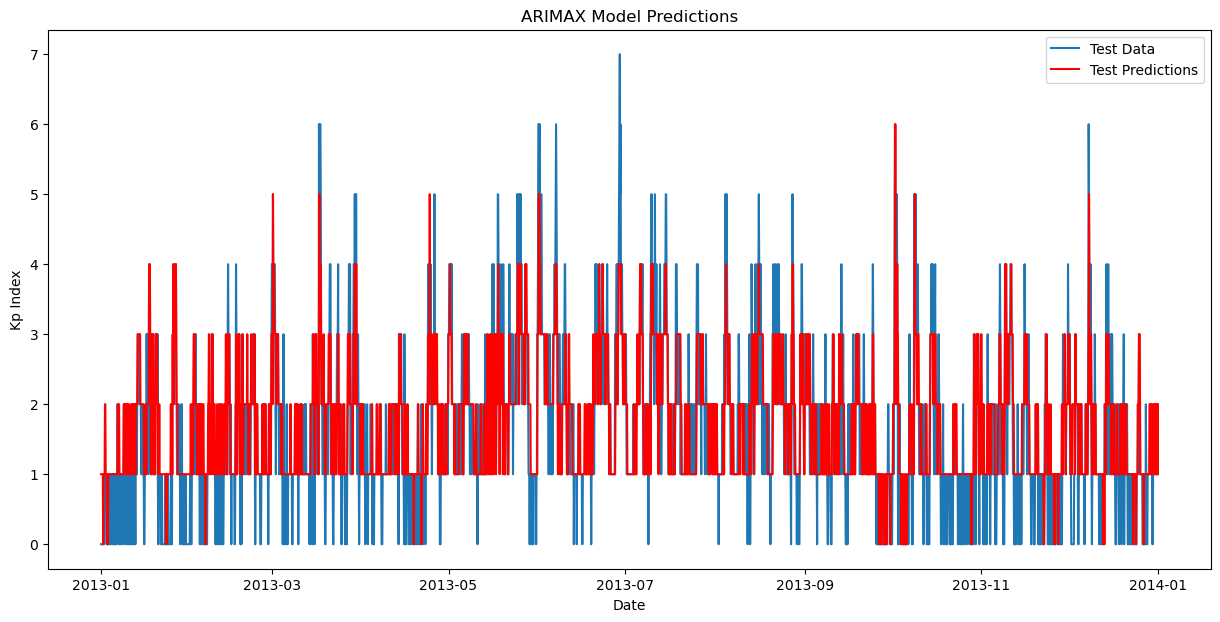

In [15]:
plt.figure(figsize=(15, 7))
plt.plot(test_Y_data_df, label='Test Data')
plt.plot(y_pred, label='Test Predictions', color='red')
plt.title('ARIMAX Model Predictions')
plt.xlabel('Date')
plt.ylabel('Kp Index')
plt.legend()
plt.show()